#### CE 537 - Module 6 - Cailee Ito

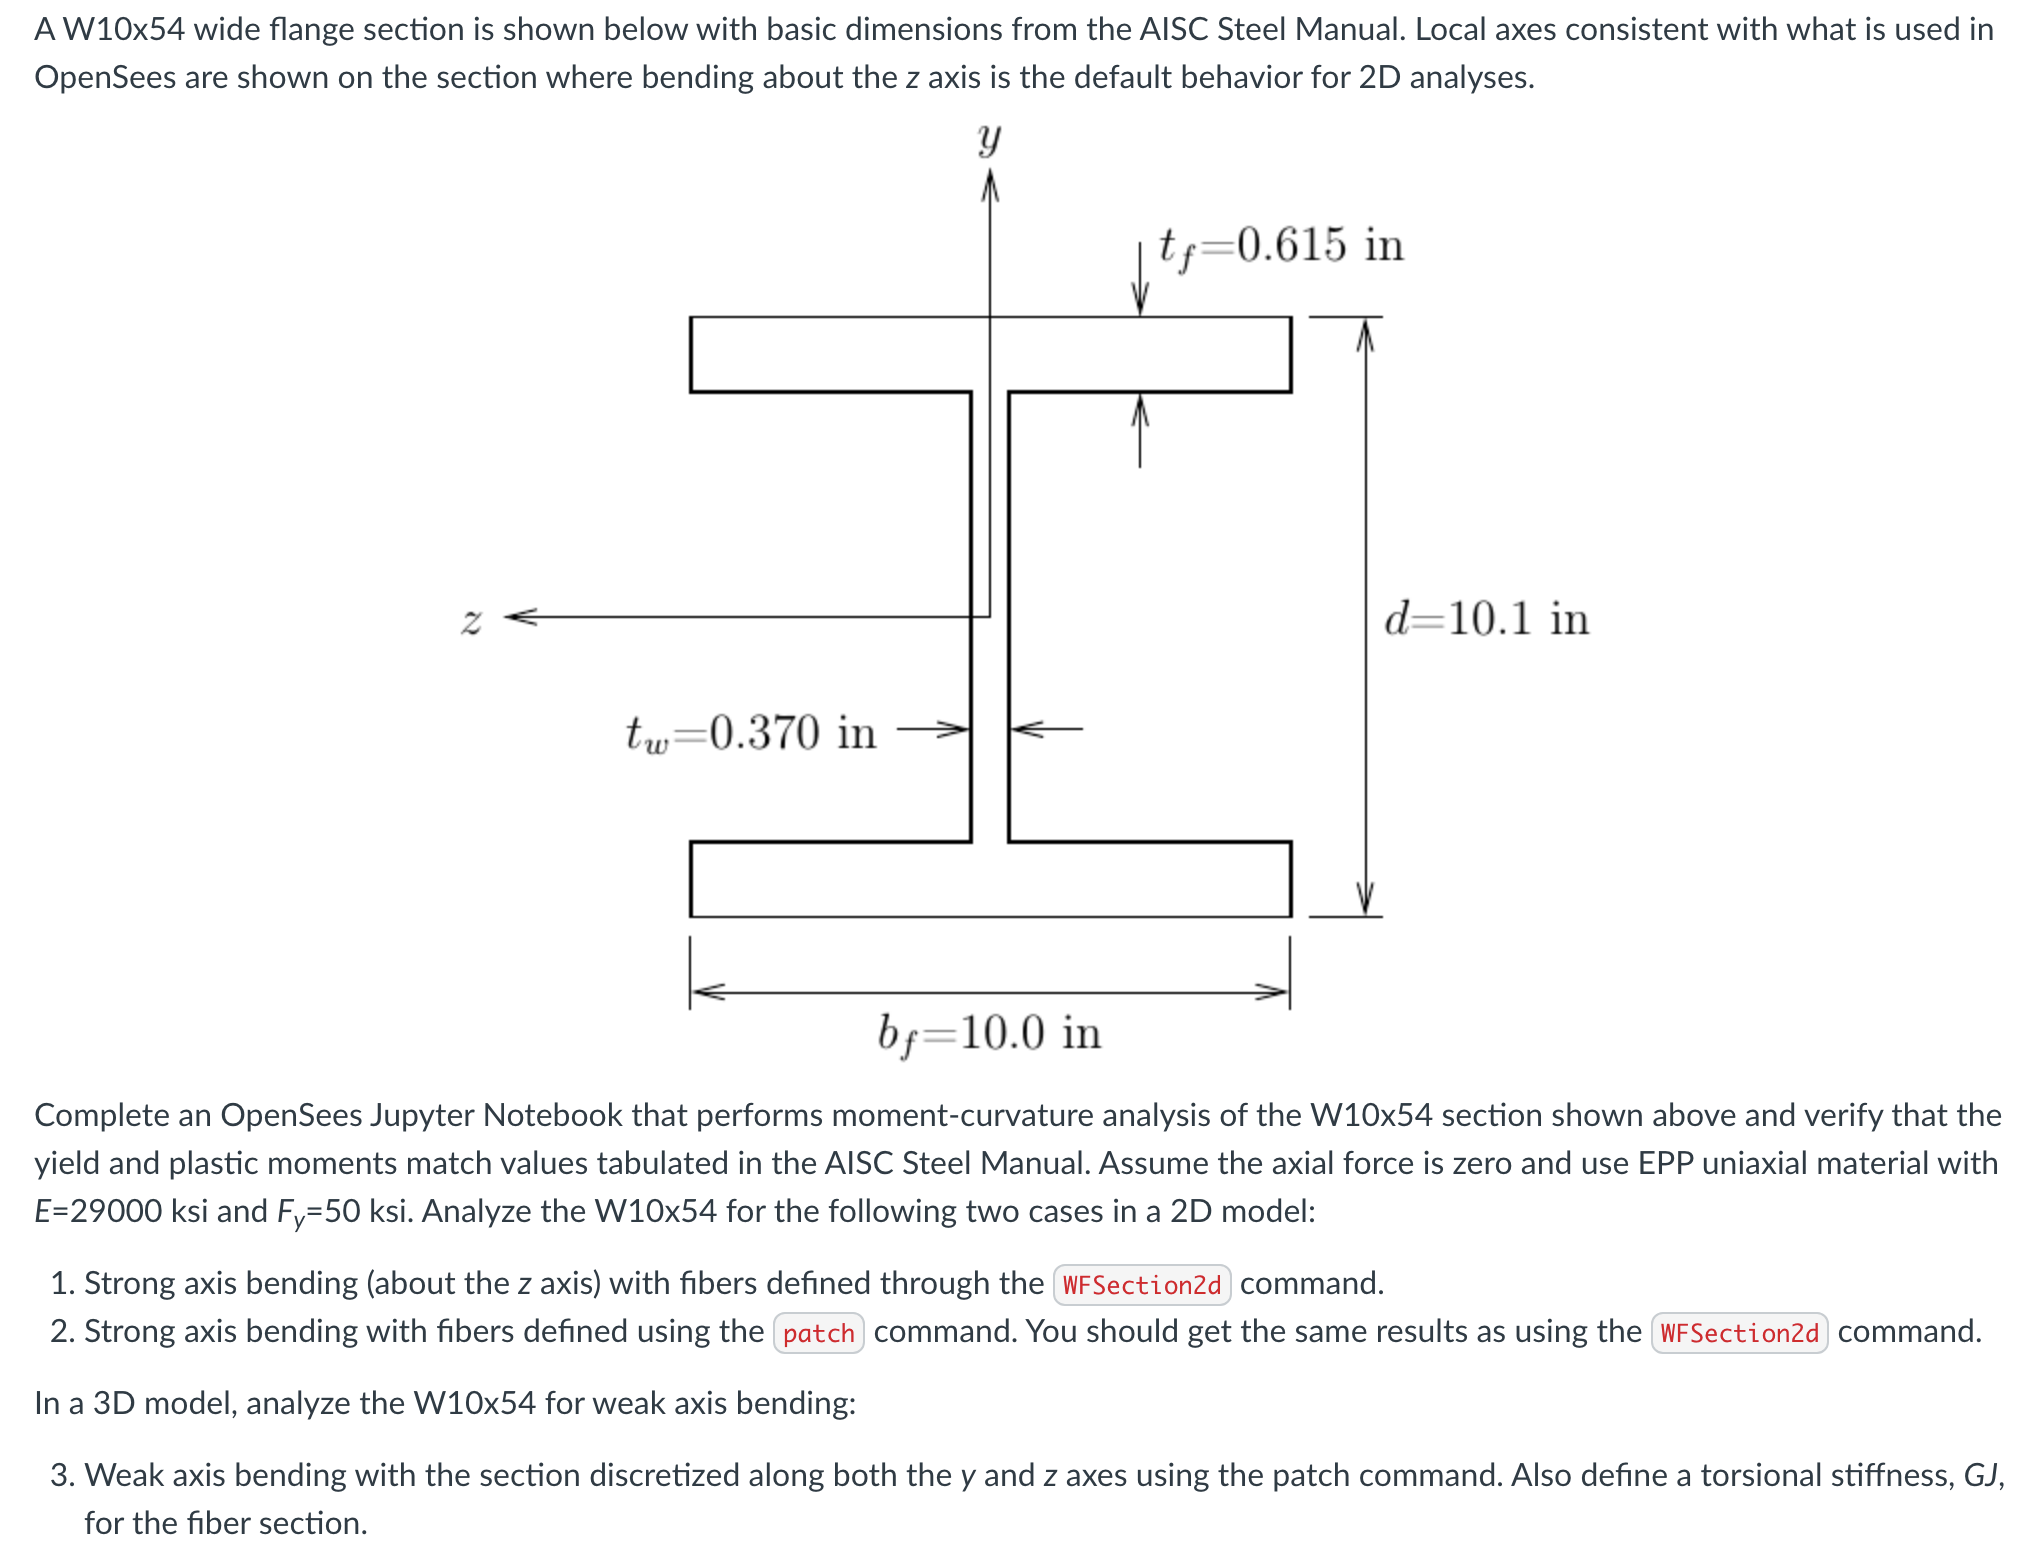

In [27]:
import openseespy.opensees as ops
import numpy as np
import matplotlib.pyplot as plt
import opsvis as opsv

In [28]:
# Assumed units: kip, in, ksi
inch = 1.0
kip = 1.0
ksi = 1.0

lbs = 1000*kip
ft = inch/12


# Material properties
Fy = 50.0*ksi
Es = 29000.0*ksi
J = 1.82*inch**4
G = 109000*ksi

# Section dimensions from Steel Manual
d = 10.1*inch
bf = 10.0*inch
tw = 0.370*inch
tf = 0.615*inch

# reference moment
M = 1
# no axial load

### Check against values in Steel Manual

In [29]:
# Section and plastic modulus
Zy = 31.3*inch**3
Zx = 66.6*inch**3
Sx = 60*inch**3
Sy = 20.6*inch**3

# Yield and plastic moment
Myx = Fy*Sx #strong
Myy = Fy*Sy #weak
Mpx = Zx*Fy #strong
Mpy = Zy*Fy #weak


print('Moment Yield = ',Myx)
print('Moment Plastic = ',Mpx)
print('Moment yield, weak = ',Myy)
print('Moment plastic, weak = ',Mpy)



GJ = J*G

Moment Yield =  3000.0
Moment Plastic =  3329.9999999999995
Moment yield, weak =  1030.0
Moment plastic, weak =  1565.0


### Moment-curvature analysis of W10x54 steel section

WARNING analysis Static - no Algorithm yet specified, 
 NewtonRaphson default will be used
WARNING analysis Static - no ConstraintHandler yet specified, 
 PlainHandler default will be used
WARNING analysis Static - no Numberer specified, 
 RCM default will be used
WARNING analysis Static - no LinearSOE specified, 
 ProfileSPDLinSOE default will be used


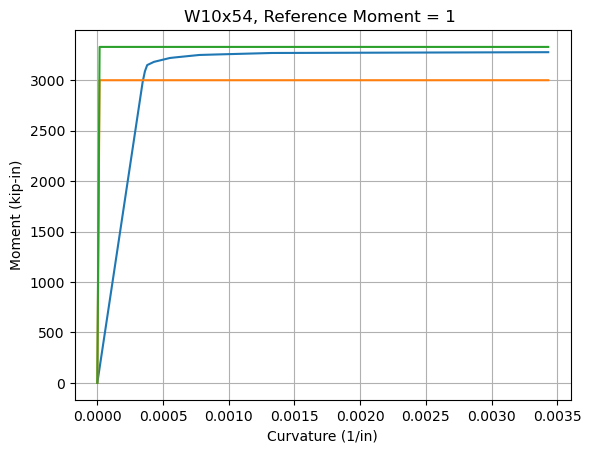

In [30]:
# 1. Strong axis bending (about the z axis) with fibers defined through the WFSection2d command.

ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

ops.node(1,0.0,0.0)
ops.node(2,0.0,0.0)

ops.fix(1,1,1,1)
ops.fix(2,0,1,0)

ops.uniaxialMaterial('Steel01',1,Fy,Es,0.0)

ops.section('WFSection2d',1,1,d,tw,bf,tf,10,2)

ops.element('zeroLengthSection',1,1,2,1)


ops.timeSeries('Constant',1)
ops.pattern('Plain',1,1)
ops.load(2,0,0.0,M)

ops.integrator('LoadControl',0.0)
ops.analysis('Static')

ops.analyze(1)

epsY = Fy/Es
epsMax = 10*epsY

y = -0.5*d # depth to extreme tension fiber
e = ops.eleResponse(1,'section','deformation')
eps = e[0] - y*e[1]

ops.timeSeries('Linear',2)
ops.pattern('Plain',2,2)
ops.load(2,0.0,0.0,1.0)

deps = 0.01*epsY
ops.integrator('DisplacementControl',2,3,deps)

Mplot = np.zeros(1)
Kplot = np.zeros(1)
Myxplot = np.zeros(1)
Mpxplot = np.zeros(1)

while eps < epsMax:
    ok = ops.analyze(1)
    if ok < 0:
        break
    
    e = ops.eleResponse(1,'section','deformation')
    eps = e[0] - y*e[1]
    
    Mplot = np.append(Mplot,ops.getLoadFactor(2))
    Kplot = np.append(Kplot,e[1])
    Myxplot = np.append(Myxplot,3000)
    Mpxplot = np.append(Mpxplot,3330)
Mpx = 3330
Myx = 3000
plt.figure()
plt.plot(Kplot,Mplot)
plt.plot(Kplot, Myxplot)
plt.plot(Kplot, Mpxplot)
plt.xlabel('Curvature (1/in)')
plt.ylabel('Moment (kip-in)')
plt.title('W10x54, Reference Moment = %d ' % M)
plt.grid()
plt.show()

#comparing to values calulated above, the values make sense!

### Strong axis bending with fibers defined using the patch command. Should get same resutls as before.


WARNING analysis Static - no Algorithm yet specified, 
 NewtonRaphson default will be used
WARNING analysis Static - no ConstraintHandler yet specified, 
 PlainHandler default will be used
WARNING analysis Static - no Numberer specified, 
 RCM default will be used
WARNING analysis Static - no LinearSOE specified, 
 ProfileSPDLinSOE default will be used


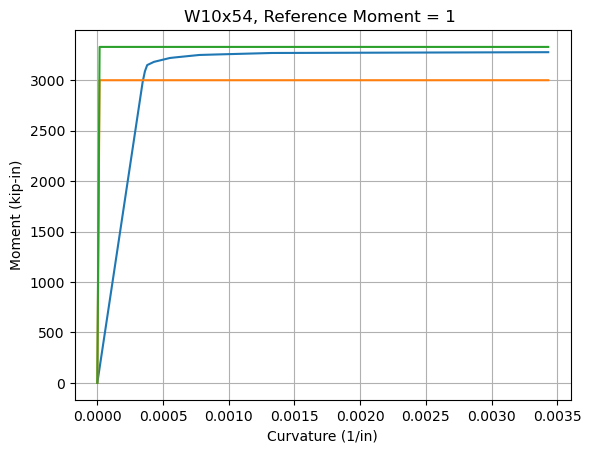

In [31]:
# 2. Strong axis bending with fibers defined using the patch command. You should get the same results as using the WFSection2d command.

ops.wipe()
ops.model('basic','-ndm',2,'-ndf',3)

ops.node(1,0.0,0.0)
ops.node(2,0.0,0.0)

ops.fix(1,1,1,1)
ops.fix(2,0,1,0)

ops.uniaxialMaterial('Steel01',1,Fy,Es,0.0)

ops.section('Fiber',1)
ops.patch('rect',1,2,1,0.5*d,0.5*bf,0.5*d-tf,-0.5*bf) # Top flange
ops.patch('rect',1,10,1,0.5*d-tf,0.5*tw,-0.5*d+tf,-0.5*tw) # Web
ops.patch('rect',1,2,1,-0.5*d+tf,0.5*bf,-0.5*d,-0.5*bf) # Bottom flange


ops.element('zeroLengthSection',1,1,2,1)


ops.timeSeries('Constant',1)
ops.pattern('Plain',1,1)
ops.load(2,0,0.0,M)

ops.integrator('LoadControl',0.0)
ops.analysis('Static')

ops.analyze(1)

epsY = Fy/Es
epsMax = 10*epsY

y = -0.5*d # depth to extreme tension fiber
e = ops.eleResponse(1,'section','deformation')
eps = e[0] - y*e[1]

ops.timeSeries('Linear',2)
ops.pattern('Plain',2,2)
ops.load(2,0.0,0.0,1.0)

deps = 0.01*epsY
ops.integrator('DisplacementControl',2,3,deps)


Mplot = np.zeros(1)
Kplot = np.zeros(1)
Myxplot = np.zeros(1)
Mpxplot = np.zeros(1)

while eps < epsMax:
    ok = ops.analyze(1)
    if ok < 0:
        break
    
    e = ops.eleResponse(1,'section','deformation')
    eps = e[0] - y*e[1]
    
    Mplot = np.append(Mplot,ops.getLoadFactor(2))
    Kplot = np.append(Kplot,e[1])
    Myxplot = np.append(Myxplot,3000)
    Mpxplot = np.append(Mpxplot,3330)
Mpx = 3330
Myx = 3000
plt.figure()
plt.plot(Kplot,Mplot)
plt.plot(Kplot, Myxplot)
plt.plot(Kplot, Mpxplot)
plt.xlabel('Curvature (1/in)')
plt.ylabel('Moment (kip-in)')
plt.title('W10x54, Reference Moment = %d ' % M)
plt.grid()
plt.show()

# comparing to the calcuated yield and plastic moments, teh values are correct

### Weak axis bending with teh section discretized along both the y and z axes using the patch command. Also define torsional stiffness, GJ, for the fiber section.

WARNING analysis Static - no Algorithm yet specified, 
 NewtonRaphson default will be used
WARNING analysis Static - no ConstraintHandler yet specified, 
 PlainHandler default will be used
WARNING analysis Static - no Numberer specified, 
 RCM default will be used
WARNING analysis Static - no LinearSOE specified, 
 ProfileSPDLinSOE default will be used


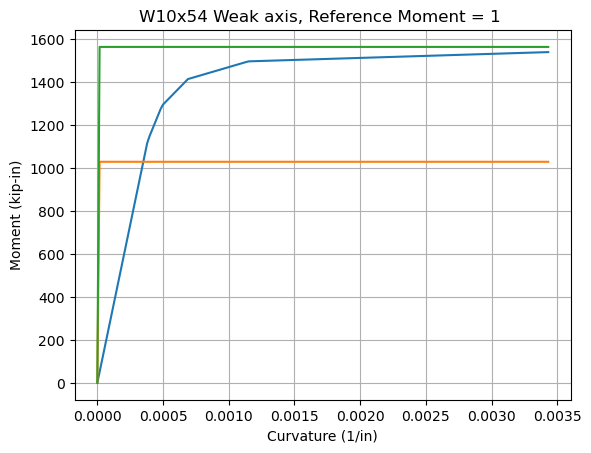

In [32]:
# 3. Weak axis bending with the section discretized along both the y and z axes using the patch command. Also define a torsional stiffness, GJ, for the fiber section.

ops.wipe()
ops.model('basic','-ndm',3,'-ndf',6)

ops.node(1,0.0,0.0,0,0,0)
ops.node(2,0.0,0.0,0,0,0)

ops.fix(1,1,1,1,1,1,1)
ops.fix(2,0,1,1,0,1,0)

ops.uniaxialMaterial('Steel01',1,Fy,Es,0.0)

ops.section('Fiber',1,'-GJ',GJ) # referncing GJ from material properties cell
ops.patch('rect',1,10,10,0.5*bf,0.5*d,-0.5*bf,0.5*d-tf) # Top flange , switch locations for weak axis
ops.patch('rect',1,10,10,0.5*tw,0.5*d-tf,-0.5*tw,-0.5*d+tf) # Web, switch locations for weak axis
ops.patch('rect',1,10,10,0.5*bf,-0.5*d+tf,-0.5*bf,-0.5*d) # Bottom flange, switchlocations for weak axis


ops.element('zeroLengthSection',1,1,2,1,0,1,0,0,0,1,1) #use zero length section command


ops.timeSeries('Constant',1)
ops.pattern('Plain',1,1)
ops.load(2,0,0.0,0,0,0,0)

ops.integrator('LoadControl',0.0)
ops.analysis('Static')

ops.analyze(1)

epsY = Fy/Es
epsMax = 10*epsY

y = -0.5*d # depth to extreme tension fiber
e = ops.eleResponse(1,'section','deformation')
eps = e[0] - y*e[1]

ops.timeSeries('Linear',2)
ops.pattern('Plain',2,2)
ops.load(2,0,0,0,0,0,1)

deps = 0.01*epsY
ops.integrator('DisplacementControl',2,6,deps)

Mplot = np.zeros(1)
Kplot = np.zeros(1)
Myxplot = np.zeros(1)
Mpxplot = np.zeros(1)

while eps < epsMax:
    ok = ops.analyze(1)
    if ok < 0:
        break
    
    e = ops.eleResponse(1,'section','deformation')
    eps = e[0] - y*e[1]
    
    Mplot = np.append(Mplot,ops.getLoadFactor(2))
    Kplot = np.append(Kplot,e[1])
    Myxplot = np.append(Myxplot,Myy)
    Mpxplot = np.append(Mpxplot,Mpy)

Mpx = Mpy
Myx = Myy
plt.figure()
plt.plot(Kplot,Mplot)
plt.plot(Kplot, Myxplot)
plt.plot(Kplot, Mpxplot)
plt.xlabel('Curvature (1/in)')
plt.ylabel('Moment (kip-in)')
plt.title('W10x54 Weak axis, Reference Moment = %d ' % M)

    
#fiber_section = [['section','Fiber',1,'-GJ',1e6],
                 #['patch','rect',1,16,1,bf/2,d/2,-bf/2,d/2-tf],
                 #['patch','rect',4,16,tw/2,d/2 - tf, -tw/2, -d/2 + tf],
                 #['patch', 'rect', 5, 16, 1, bf/2, -d/2 + tf, -bf/2, -d/2],]
#opsv.plot_fiber_section(fiber_section)

plt.grid()
plt.show()

# after comparing to the calcualted weak axis plastic and yield moment, the values are correct